In [20]:
import numpy as np
import tensorflow as tf
from PIL import Image
import time
import cv2
import yaml
import matplotlib.pyplot as plt

class Object_Detector():
    def __init__(self, model_path):
        self.__load_model(model_path)
        print('model loaded')

    def __load_model(self, model_path):
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(model_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        config = tf.ConfigProto()
        config.gpu_options.allow_growth= True

        with self.detection_graph.as_default():
            self.sess = tf.Session(config=config, graph=self.detection_graph)
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

        # load label_dict
        self.label_dict = {1: 'fish'}
        
        # warmup
        self.detect_image(np.ones((600, 600, 3)))

    def detect_image(self, image_np, score_thr=0.5, print_time=False):
        image_w, image_h = image_np.shape[1], image_np.shape[0]
    
        # Actual detection.
        t = time.time()
        (boxes, scores, classes, num) = self.sess.run(
          [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
          feed_dict={self.image_tensor: np.expand_dims(image_np, axis=0)})
        if print_time:
            print('detection time :', time.time()-t)
        # Visualization of the results of a detection.
        for i, box in enumerate(boxes[scores>score_thr]):
            top_left = (int(box[1]*image_w), int(box[0]*image_h))
            bottom_right = (int(box[3]*image_w), int(box[2]*image_h))
            cv2.rectangle(image_np, top_left, bottom_right, (0,255,0), 3)
            cv2.putText(image_np, self.label_dict[int(classes[0,i])], top_left, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        return image_np

In [25]:
MODEL_PATH = 'fish_ssd_fpn_graph/frozen_inference_graph.pb'
# MODEL_PATH = 'fish_detection_graph/frozen_inference_graph.pb'
object_detector = Object_Detector(MODEL_PATH)

model loaded


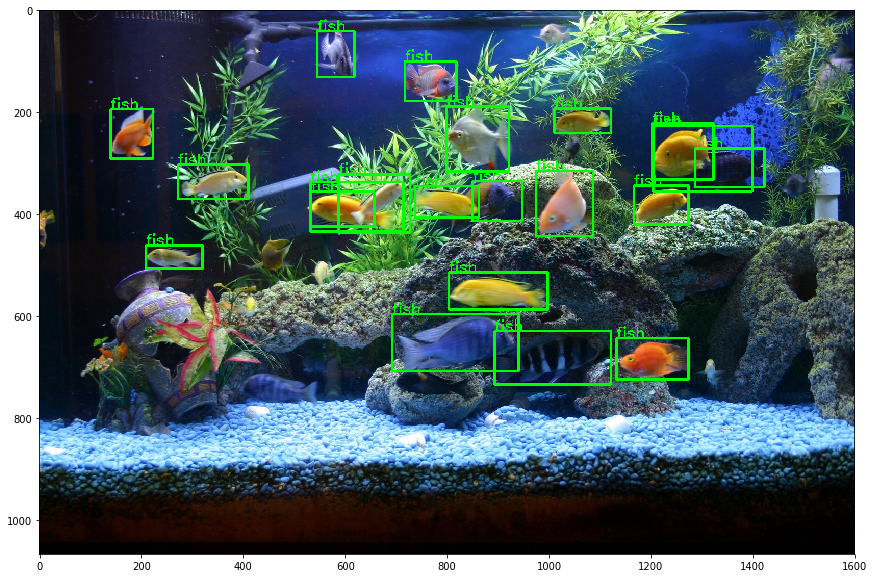

In [33]:
img = cv2.imread('/home/ubuntu/workspace/models/research/object_detection/test_images/image8.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_ = object_detector.detect_image(img, score_thr=0.2)
plt.figure(figsize=(20, 10))
plt.imshow(img_)